In [1]:
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.utils import to_categorical

# We will use Shakespeare Sonnet 2
sample_corpus_sonnet = ["""When forty winters shall besiege thy brow,
    And dig deep trenches in thy beauty's field,
    Thy youth's proud livery so gazed on now,
    Will be a totter'd weed of small worth held:
    Then being asked, where all thy beauty lies,
    Where all the treasure of thy lusty days;
    To say, within thine own deep sunken eyes,
    Were an all-eating shame, and thriftless praise.
    How much more praise deserv'd thy beauty's use,
    If thou couldst answer 'This fair child of mine
    Shall sum my count, and make my old excuse,'
    Proving his beauty by succession thine!
    This were to be new made when thou art old,
    And see thy blood warm when thou feel'st it cold."""]

sample_corpus_toy_sentences = [
    "The thief stole.",
    "The thief stole the suitcase.",
    "The crook stole the suitcase.",
    "The cop took a bribe.",
    "The thief was arrested by the detective."
]


class NGramDataset:

    def __init__(self, corpus='sonnet', ngram_size=3):
        self.ngram_size = ngram_size
        self.corpus = corpus
        self.tokenizer = Tokenizer(oov_token='<UNK>')
        if corpus == 'sonnet':
            self.X = self.load(sample_corpus_sonnet)
        elif corpus == 'toy':
            self.X = self.load(sample_corpus_toy_sentences)
        else:
            raise Exception('The value for corpus should be either "sonnet" or "toy"')

    '''
        Add special 'Start Of Sentence' (<sos>) and 'End of Sentence' (<eos>) symbols in the beginning and end of sentences.
        This helps learn to predict words at the beginning and end of sentences.
    '''
    def preprocess(self, sentence):
        prefix = " ".join(["<sos>" for i in range(1, self.ngram_size)])
        suffix = " ".join(["<eos>" for i in range(1, self.ngram_size)])
        return "{} {} {}".format(prefix, sentence, suffix)

    '''
    Convert sentence(s) of words into sequences of indexes. 
    '''
    def vectorize(self, sentences):
        return self.tokenizer.texts_to_sequences(sentences)

    def get_ngrams(self, sequence):
        ngrams = []
        for i in range(0, len(sequence) - self.ngram_size + 1):
            ngrams.append([sequence[k] for k in range(i, i + self.ngram_size)])
        return ngrams

    def load(self, corpus):
        corpus_with_sos_eos = []
        for sentence in corpus:
            corpus_with_sos_eos.append(self.preprocess(sentence))

        # Tokenize and convert to indexes
        self.tokenizer.fit_on_texts(corpus_with_sos_eos)
        sequences = self.vectorize(corpus_with_sos_eos)

        # Create a list of all ngrams found in all the sentences
        ngram_list = []
        for sequence in sequences:
            ngram_list += self.get_ngrams(sequence)
        # return the tokenizer (useful for converting back from indexes to words, etc) and
        # the list of ngrams as an np.array with shape (num_of_ngrams, ngram_size)
        return np.array(ngram_list)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    loss = history.history['loss']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(7, 5))
    plt.plot(x, loss, 'b', label='Training loss')
    plt.title('Training loss')
    plt.legend()
    plt.show()

In [3]:
from keras.models import Sequential
from keras import layers
from keras.utils import np_utils
import numpy as np


class LanguageModel:
    def __init__(self, ngram_size, tokenizer):
        self.ngram_size = ngram_size
        self.tokenizer = tokenizer
        self.model = Sequential()
        # TODO: Implement
        

    def train(self, train_X, epochs, batch_size, embedding_dim):
        # TODO: Implement
        train_X, train_y = train_X[:,:-1], train_X[:,-1]      # separate features and labels
        one_hot_train_y = np_utils.to_categorical(train_y)    # convert labels to one-hot
        vocab_size = len(self.tokenizer.word_index) + 1       # calculate number of unique vocab

        # add layers
        self.model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim))
        self.model.add(layers.GlobalAveragePooling1D())
        self.model.add(layers.Dense(10, activation='relu'))
        self.model.add(layers.Dense(vocab_size, activation='softmax'))

        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
        self.model.summary()

        # fit model with training data
        history = self.model.fit(train_X, one_hot_train_y, epochs=epochs, batch_size=batch_size)

        return history

    def predict(self, context):
        # TODO: Implement
        logits = self.model.predict(context)      # predict probability of next words when given context
        pred_index = np.argmax(logits[0])         # get index of word with highest probability
        return pred_index, logits[0]

    def generate(self, context, max_num_words=20):
        output = []
        context1 = context[0]
        # TODO: Implement
        # generate next max_num_words given context
        for i in range(max_num_words):
          last = [context1[-2:]]      # input bigrams
          last = np.array(last)
          pred_index, logits = self.predict(last)       # predict probabilities of next word
          text = self.tokenizer.index_word[pred_index]  # convert index to word
          output.append(text)             # add word to output list
          context1.append(pred_index)     # add word index to list for next words

        return output

    def sent_log_likelihood(self, ngrams):
        logprob = 1

        # TODO: Implement
        for n in range(0,len(ngrams)):
          first = [ngrams[n][0:2]]        # input bigrams
          pred_index, logits = self.predict(first)      # predict probabilities of next word
          prob = logits[ngrams[n][2]]       # get probability of the actual word
          logprob = logprob * prob          # multiply all probabilities

        return logprob

    def fill_in(self, prefix, suffix, get_ngrams_fn):
        # TODO: Implement (MSc Students only)
        logits = []
        pred_word_id = 0
        return pred_word_id, logits

    def get_word_embedding(self, word):
        return self.model.layers[0].get_weights()[0][self.tokenizer.word_index[word]]

In [12]:
def exercises_sonnet():
  print("Start implementing exercises_sonnet()")
  # Exercise 1: Fit a 3-gram Language Model on the Sonnet dataset. Plot the training loss histogram.
  # You will only need to implement LanguageModel.__init__() and LanguageModel.train().
  # To help you get started, we are giving you the scaffolding for calling the dataset loader, model builder, training
  # and plotting.

  # Init hyperparameters
  corpus = "sonnet"
  ngram_size = 3
  epochs = 200
  batch_size = 8
  embedding_dim = 100

  # Create dataset of ngrams
  dataset = NGramDataset(corpus=corpus, ngram_size=ngram_size)

  # Create Language Model (LM)
  lm = LanguageModel(ngram_size, dataset.tokenizer)

  # Train LM
  history = lm.train(dataset.X, epochs=epochs, batch_size=batch_size, embedding_dim=embedding_dim)
  # Plot training curve
  # TODO: Uncomment once you have implemented the model!
  plot_history(history)
  plt.plot(history.history['accuracy'])     # plot accuracy curve

  # Exercise 2: Predict the next word and probability score given the bigram 'all the'.
  # You will need to implement LanguageModel.predict() AND call it below with 'context_vec' as the argument.
  context = ['all the']
  context_vec = dataset.vectorize(context)
  pred_index, logits = lm.predict(context_vec)
  # TODO:  Complete the Implementation
  print("all the: ", dataset.tokenizer.index_word[pred_index])    # print predicted word
  print("Probability: ", logits[pred_index])      # print probability of predicted word

  # Exercise 3: Generate some random text (20 words), starting with '<sos> <sos>'. (Optional) you can try with
  # different initial contexts!
  # You will need to implement LanguageModel.generate()
  context = ['<sos> <sos>']
  context_vec = dataset.vectorize(context)
  text = lm.generate(context_vec)       # generate next max_num_words words
  print(" ".join(text))         # join words

In [14]:
def exercises_toy():
  # Exercise 4a: Fit a 3-gram Language Model on the Toy Dataset. Plot the training loss histogram.
  # You will need to write the scaffolding below on your own.
  #TODO: Complete the implementation
  corpus = "toy"
  ngram_size = 3
  epochs = 200
  batch_size = 8
  embedding_dim = 100

  dataset = NGramDataset(corpus=corpus, ngram_size=ngram_size)
  lm = LanguageModel(ngram_size, dataset.tokenizer)

  history = lm.train(dataset.X, epochs=epochs, batch_size=batch_size, embedding_dim=embedding_dim)

  # plot histogram of training loss
  plot_history(history)

  # Exercise 4b: Predict the next word given the bigram '<sos> the'.
  # Why is the next word 'thief' and not 'crook'? Justify by looking at the dataset and the predicted probabilities.
  # You will need to write the scaffolding below on your own.
  # TODO: Complete the Implementation
  context = ['<sos> the']
  context_vec = dataset.vectorize(context)
  pred_index, logits = lm.predict(context_vec)

  print("<sos> the: ", dataset.tokenizer.index_word[pred_index])
  print("Probability of 'thief': ", logits[pred_index])
  print("Probability of 'crook': ", logits[dataset.tokenizer.word_index['crook']])

  # Exercise 5: Which of the two sentences S1: 'The thief stole the suitcase.' and S2: 'The crook stole the suitcase.'
  # is more likely? Justify by looking at the dataset and computing the sentence likelihoods.
  # You will need to implement LanguageModel.sent_log_likelihood()
  sentence_1 = 'The thief stole the suitcase.'
  sentence_2 = 'The crook stole the suitcase.'
  sent_1_ngrams = dataset.get_ngrams(dataset.vectorize([dataset.preprocess(sentence_1)])[0])
  sent_2_ngrams = dataset.get_ngrams(dataset.vectorize([dataset.preprocess(sentence_2)])[0])
  
  # calculate likelihood of Sentences 1 and 2
  log_likelihood_1 = lm.sent_log_likelihood(sent_1_ngrams)
  log_likelihood_2 = lm.sent_log_likelihood(sent_2_ngrams)
  print("P(S1)=", log_likelihood_1)
  print("P(S2)=", log_likelihood_2)

  # Exercise 6: Trained Word Embeddings. Which embeddings are closer? Compare the embeddings of 'thief' and 'crook'
  # to 'thief' and 'cop'. Justify your answer by computing the cosine similarities. Does the result follow the dataset?
  # You will need to implement the cosine similarity. Use lm.get_word_embedding() to get the word embeddings.

  # TODO: Implement cosine similarity
  thief = lm.get_word_embedding("thief")
  crook = lm.get_word_embedding("crook")
  cop = lm.get_word_embedding("cop")

  thief_crook = np.dot(thief, crook)/(np.linalg.norm(thief)*np.linalg.norm(crook))
  thief_cop = np.dot(thief, cop)/(np.linalg.norm(thief)*np.linalg.norm(cop))
  print("Cosine Similarity of 'thief' and 'crook': ", thief_crook)
  print("Cosine Similarity of 'thief' and 'cop': ", thief_cop)

Start implementing exercises_sonnet()
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         9200      
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dense_1 (Dense)              (None, 92)                1012      
Total params: 11,222
Trainable params: 11,222
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
15/15 [==============================] - 0s 2ms/step - loss: 4.5230 - accuracy: 0.0084
Epoch 2/200
15/15 [==============================] - 0s 2ms/step - loss: 4.5101 - accuracy: 0.1008
Epoch 3/200
15

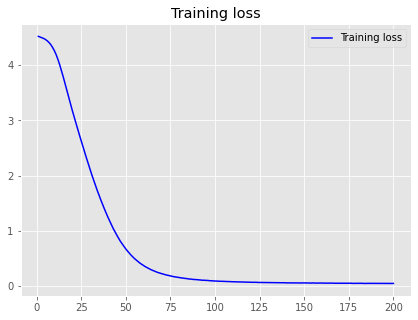

all the:  treasure
Probability:  0.9937641
when forty winters shall besiege thy brow and dig deep trenches in thy beauty's use if thou couldst answer 'this


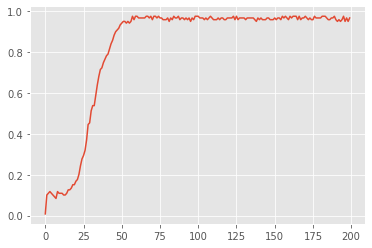

In [6]:
exercises_sonnet()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1700      
_________________________________________________________________
global_average_pooling1d_5 ( (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_11 (Dense)             (None, 17)                187       
Total params: 2,897
Trainable params: 2,897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
5/5 [==============================] - 0s 3ms/step - loss: 2.8331 - accuracy: 0.0857
Epoch 2/200
5/5 [==============================] - 0s 2ms/step - loss: 2.8153 - accuracy: 0.3143
Epoch 3/200
5/5 [==============================] - 0s 2m

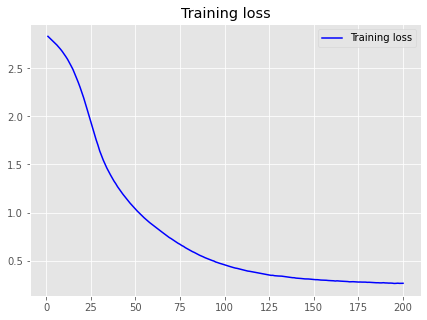

<sos> the:  thief
Probability of 'thief':  0.55324584
Probability of 'crook':  0.23766291
P(S1)= 0.1354482251938421
P(S2)= 0.2072872277360521
Cosine Similarity of 'thief' and 'crook':  0.7013546
Cosine Similarity of 'thief' and 'cop':  -0.10107534


In [15]:
# Implement first before executing!
exercises_toy()